In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict

## Nahrej ze souboru data a vrať je

In [2]:
def _extract_meta(file_name: str) -> Tuple[float, float, float]:
    """z=7.5cm_P0=10uW_PM=29.78mW -> z, P0, PM"""
    return [float(e.split("=")[1][:-2]) for e in file_name.split("_")]

def fetch(path: str) -> Dict:
    x_arr = [] # v mm
    P_arr = [] # v mW
    z, P0, PM = _extract_meta(os.path.basename(path).strip(".csv")) # v cm, uW, mW
    with open(path, "r") as f:
        f.readline()
        while line := f.readline():
            x, P = [float(i) for i in line.split(";")]
            x_arr.append(x) 
            P_arr.append(P)
    return {
        "z": z * 10, # cm -> mm
        "P0": P0 *10**(-3), # uW -> mW
        "PM": PM,
        "x": x_arr,
        "P": P_arr
    } 

## Vypočti X0
x0 je poloha při které jsme ve středu svazku. Tj výkon je přesně v polovině maxima!

In [3]:
def linear_aprox(p1, p2, x1, x2, p_val) -> float:
    a = (p1 - p2) / (x1 - x2)
    b = p1 - a*x1
    x_val = (p_val - b) / a
    return x_val 

def get_x0(x: list, P: list, PM: float):
    p_closest = min(P, key=lambda p: abs(p-PM/2))
    i_bef = -1
    if p_closest < PM/2:
        i_bef = P.index(p_closest)
    elif p_closest > PM/2:
        i_bef = P.index(p_closest) - 1
    else:
        return x[P.index(p_closest)]
    # from values around half power approximates x for half the power, hence the center of the beam
    return linear_aprox(P[i_bef], P[i_bef + 1], x[i_bef], x[i_bef + 1], PM/2)

In [4]:
import os 
DATA_DIRECTORY = r"C:\Users\Student\Desktop\David Tomeček\dp-beam-scan-knife-edge\data"
INPUT_DATA = []
for file in [f for f in os.listdir(DATA_DIRECTORY) if f.endswith(".csv")]:
    data = fetch(os.path.join(DATA_DIRECTORY, file))
    data["x0"] = get_x0(data["x"], data["P"], data["PM"])
    INPUT_DATA.append(data)
print(f"Sucesfully loaded {len(INPUT_DATA)} files, which goes followingly:")
INPUT_DATA = sorted(INPUT_DATA, key=lambda x: x['z'])
for data in INPUT_DATA:
    print(f"z={data['z']}mm P0={data['P0']}mW PM={data['PM']}mW x0={data['x0']}mm")



Sucesfully loaded 5 files, which goes followingly:
z=75.0mm P0=0.01mW PM=29.78mW x0=4.526495726495726mm
z=125.0mm P0=0.01mW PM=29.78mW x0=3.8720125786163524mm
z=1238.0mm P0=0.05mW PM=25.65mW x0=4.206914893617021mm
z=1338.0mm P0=0.05mW PM=25.65mW x0=5.185364208633093mm
z=1488.0mm P0=0.03mW PM=25.4mW x0=4.532894736842104mm


## Fitování dat na křivku výkonu
Viz https://people.fjfi.cvut.cz/blazejos/public/ul7en.pdf
$$
    P = P_0 + \frac{P_{max}}{2}(1 - erf(\frac{\sqrt{2}(x - x_0)}{w}))
$$

In [5]:
from scipy.optimize import curve_fit
from scipy import special

def power_fit_function(x: list, w: float, x0: float, P0: float, PM: float):
    return P0 + (PM/2) * (1 + special.erf(np.sqrt(2) * (x - x0) / w))

z=75.0 w=0.9334513996205196


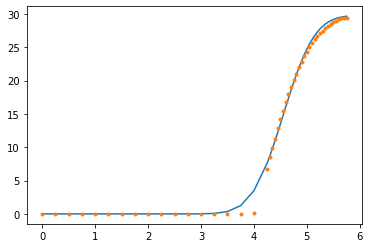

z=125.0 w=0.821622713594677


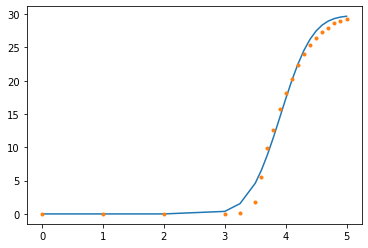

z=1238.0 w=0.646158316623103


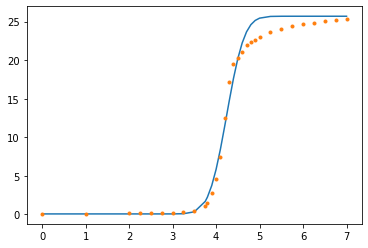

z=1338.0 w=0.6849434038850972


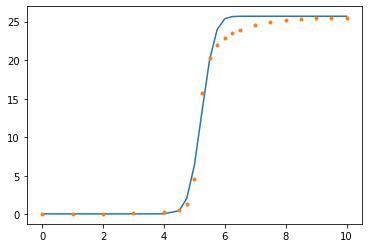

z=1488.0 w=0.9206926105065839


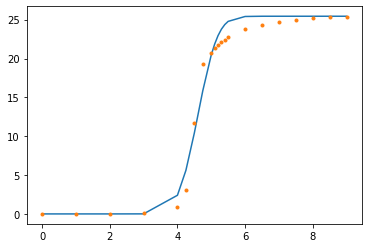

In [9]:
w_arr = []
for data in INPUT_DATA:
    fit_func = lambda x, w, x0: power_fit_function(x, w, x0=x0, P0=data["P0"], PM=data["PM"])
    popt, _ = curve_fit(fit_func, data["x"], data["P"], p0 = [0.9, 4.5])
    w, x0 = popt
    print(f"z={data['z']} w={w}")
    w_arr.append(w)
    plt.plot(data["x"], [fit_func(x, w, x0) for x in data["x"]], "-")
    plt.plot(data["x"], data["P"], ".")
    plt.show()

w_arr = np.array(w_arr)

## Vývoj poloměru svzaku při propagaci

Jelikož první dvě měření relativně dobře odpovídají teorii, tak budu počítat s nimi (není ideálí, ale v tuto chvíli nic lepšího nemám (??))

In [11]:
def beam_radius(z, w0, w_loc, WL):
    zr = np.pi * w0**2 * 1 / WL
    return w0 * np.sqrt(1 + ((z - w_loc) / zr)**2)

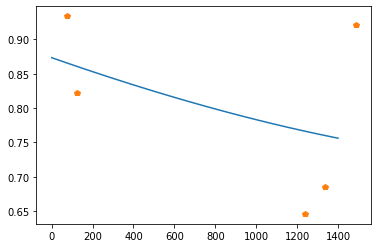

In [13]:
WL = 405e-6
z_arr = [i["z"] for i in INPUT_DATA]
fit_func = lambda z, w0, w_loc: beam_radius(z, w0, w_loc, WL)
popt, _ = curve_fit(fit_func, z_arr, w_arr)
w0, w_loc = popt

z_arr_fit = np.linspace(0,1400)

zr_mm = (np.pi * w0**2 * 1 / WL)
plt.plot(z_arr_fit, fit_func(z_arr_fit, w0, w_loc))
plt.plot(z_arr, w_arr, "p")
plt.show()




## Hledání optimální polohy čočky 

Mám funkci $f: d \rightarrow [w, z_w]$, který mi polohu čočky $d$ zobrazí na velikost krčku $w$ a polohu krčku $z_w$. Pro fitování definuji funkci
    $$
    F(d, w_{opt}, z_{opt}) \equiv ||f(d) - [w_{opt}, z_{w, opt}]||^2 \\
    d \geq 0 \\
    |w_{opt} - W_{beninkt, opt}| \leq TOLERANCE \\
    z_{w, opt} \geq 0
    $$

In [32]:
from optix.beams import GaussianBeam
from optix.optical_system import OpticalPath
from optix.ABCDformalism import *
gb = GaussianBeam(405e-9, waist_location=w_loc*10**(-3), zr=zr_mm * 10**(-3))
OPTIMUM_WAIST_RADIUS = 17.751421063770742e-6

def fit_function(d: float, f: float, gb: GaussianBeam) -> float:
    op = OpticalPath()
    op.append(FreeSpace(d))
    op.append(ThinLens(f))
    output = op.propagate(gb)
    return np.array([output.waist_radius, output.waist_location])


fit_func = lambda params: np.linalg.norm(fit_function(params[0], 400e-3, gb) - np.array([params[1], params[2]]))**2

from scipy.optimize import minimize
cons = ({
    'type': 'ineq',
    'fun': lambda params: params[0]
},
{
    'type': 'ineq',
    'fun': lambda params: 5e-6 - abs(params[1] - OPTIMUM_WAIST_RADIUS)
},
{
    'type': 'ineq',
    'fun': lambda params: params[2]
})



result = minimize(fit_func, [5e-2,OPTIMUM_WAIST_RADIUS, 40e-2], constraints=cons)
print(result)






     fun: 1.3979581337611044e-09
     jac: array([-1.78748287e-06, -7.47419779e-05,  1.81533806e-06])
 message: 'Optimization terminated successfully'
    nfev: 9
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([3.63164437e-02, 1.91197767e-05, 4.16568032e-01])


In [33]:
f = 400e-3
d = 3.63e-2

op = OpticalPath()
op.append(FreeSpace(d))
op.append(ThinLens(f))
output = op.propagate(gb)
print(output)

z = np.linspace(0, 1, 1000)
w = output.beam_radius(z)

plt.plot(z, w)



        amplitude	=	1,
        wavelength	=	405.0 nm,
        waist_loc	=	41.655066516759874 cm,
        waist_rad	=	0.056498101532951366 mm,
        rayleigh_r	=	24.760679516048977 mm,
        divergence	=	2.281767004670907 mrad
        
